In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import SGDClassifier
import numpy as np

In [8]:
x, y = load_breast_cancer(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

### Tuning parameters

In [9]:
clf = SGDClassifier()
parameter_grid = {"alpha": (1e-4, 1), "epsilon": (0.01, 0.1)}
x_train_tune, x_test_tune, y_train_tune, y_test_tune = train_test_split(x_train, y_train, test_size=.2, random_state=29)

In [10]:
tune_search = TuneSearchCV(
    clf,
    parameter_grid,
    search_optimization="bayesian",
    n_trials=10,
    early_stopping="ASHAScheduler",
    max_iters=3,
    local_dir='.',
    return_train_score=True,
    verbose=1
)
tune_search.fit(x_train_tune, y_train_tune)

TuneSearchCV(early_stopping=<ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x7f575143ad10>,
             estimator=SGDClassifier(), local_dir='.',
             loggers=[<class 'ray.tune.logger.JsonLogger'>,
                      <class 'ray.tune.logger.CSVLogger'>],
             max_iters=3, n_jobs=-1,
             param_distributions={'alpha': (0.0001, 1), 'epsilon': (0.01, 0.1)},
             return_train_score=True,
             scoring={'score': <function _passthrough_scorer at 0x7f575536cf80>},
             search_optimization='bayesian', sk_n_jobs=1, verbose=1)

In [11]:
print(tune_search.best_params_)

{'alpha': 0.2160294545823589, 'epsilon': 0.02554815894166721}


In [12]:
# best classifier
clf = SGDClassifier(**tune_search.best_params_)
clf.fit(x_train_tune, y_train_tune)
clf.score(x_test_tune, y_test_tune)

0.872093023255814

### Training local models

In [49]:
def tuning(learners, local_ds, theta, theta_dist):
    global_predictions = []
    global_dist = []
    for learner in learners:
        global_predictions.append(learner.predict(global_set_x))
        global_dist.append(learner.decision_function(global_set_x))
    global_predictions = np.array(global_predictions)
    
    certain_global_x = []
    certain_global_predictions = []
    correct_count = 0
    for i in range(len(global_set_x)):
        tmp = np.zeros(n_classes)
        tmp_dist = 0.0
        for ind, pred in enumerate(global_predictions[:, i]):
            tmp[pred] += 1
            tmp_dist += abs(global_dist[ind][i])
        if tmp.max() >= theta and tmp_dist >= theta_dist:
            certain_global_x.append(global_set_x[i])
            certain_global_predictions.append(np.argmax(tmp))
            if np.argmax(tmp) == global_set_y[i]:
                correct_count += 1
    #print("Certain predictions amount", len(certain_global_predictions), "with correct in them", correct_count)
    
    learners = []
    acc = 0
    for i in range(n_learners):
        clf = SGDClassifier(**tune_search.best_params_)
        if len(certain_global_x) > 0:
            local_X = np.vstack([local_set_x[i*local_ds:(i+1)*local_ds], certain_global_x])
            local_Y = np.hstack([local_set_y[i*local_ds:(i+1)*local_ds], certain_global_predictions])
        else:
            local_X = local_set_x[i*local_ds:(i+1)*local_ds]
            local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        clf.fit(local_X, local_Y)
        acc += clf.score(x_test, y_test)
        learners.append(clf)
    #print("Average accuracy of local workers", acc/n_learners)
        
    return learners, acc/len(learners)

In [36]:
print("Data size", len(x_train))
n_classes = len(np.unique(y_train))
print("classes", n_classes)

Data size 426
classes 2


In [44]:
# unlabeled examples
m = 300
global_set_x = x_train[:m]
global_set_y = y_train[:m]
# labeled examples
local_set_x = x_train[m:]
local_set_y = y_train[m:]
n = len(x_train) - m
n_learners = 5
theta = 4
theta_dist = 4*500.0
local_ds = n//n_learners
print("Length of the local dataset", local_ds)

Length of the local dataset 25


In [46]:
learners = []
acc = 0
for i in range(n_learners):
    clf = SGDClassifier(**tune_search.best_params_)
    local_X = local_set_x[i*local_ds:(i+1)*local_ds]
    local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
    #print(Counter(local_Y))
    clf.fit(local_X, local_Y)
    acc += clf.score(x_test, y_test)
    learners.append(clf)
print("Average accuracy of local workers", acc/n_learners)

Average accuracy of local workers 0.7146853146853147


In [47]:
for i in range(20):
    learners, acc = tuning(learners, local_ds, theta, theta_dist)
    print(acc)

Certain predictions amount 187 with correct in them 180
0.8377622377622378
Certain predictions amount 222 with correct in them 205
0.7944055944055944
Certain predictions amount 263 with correct in them 240
0.8601398601398602
Certain predictions amount 206 with correct in them 195
0.8643356643356643
Certain predictions amount 221 with correct in them 209
0.8545454545454545
Certain predictions amount 193 with correct in them 183
0.8531468531468531
Certain predictions amount 228 with correct in them 216
0.827972027972028
Certain predictions amount 202 with correct in them 192
0.834965034965035
Certain predictions amount 146 with correct in them 138
0.786013986013986
Certain predictions amount 201 with correct in them 192
0.7846153846153846
Certain predictions amount 115 with correct in them 107
0.8167832167832166
Certain predictions amount 199 with correct in them 187
0.8741258741258742
Certain predictions amount 204 with correct in them 195
0.8237762237762238
Certain predictions amount 1

### Random runs

In [54]:
accs = []
for i in range(50):
    learners = []
    accs.append([])
    acc = 0
    for i in range(n_learners):
        clf = SGDClassifier(**tune_search.best_params_)
        local_X = local_set_x[i*local_ds:(i+1)*local_ds]
        local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        #print(Counter(local_Y))
        clf.fit(local_X, local_Y)
        acc += clf.score(x_test, y_test)
        learners.append(clf)
    accs[-1].append(acc/n_learners)
    for i in range(20):
        learners, acc = tuning(learners, local_ds, theta, theta_dist)
        accs[-1].append(acc)

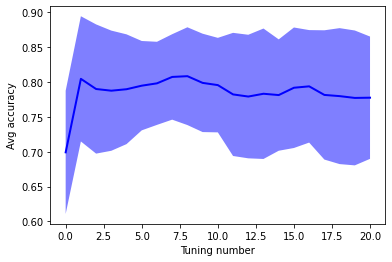

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

mu = np.array(accs).mean(axis=0)
sigma = np.array(accs).std(axis=0)

plt.plot(range(21), mu, lw=2, label='mean', color='blue')
plt.fill_between(range(21), mu+sigma, mu-sigma, facecolor='blue', alpha=0.5)

plt.ylabel("Avg accuracy")
plt.xlabel("Tuning number")
plt.show()